In [1]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:0'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal Length M=20000


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def cosFactor(av,bv):
    #pdb.set_trace()
    f = 0
    cosSIM = 1.0
    try:
        currentCOS = np.dot(av, bv)/(np.linalg.norm(av)*np.linalg.norm(bv))
    except: # catch *all* exceptions
        f = sys.exc_info()[0]
        print(f)
        currentCOS = [0.0] # If error default orthogonal
        
    
    if(not f):
        if(np.any(np.isnan(currentCOS))): # If NaN default to orthogonal
            currentCOS = [0.0]
        cosSIM = 1 - currentCOS[0]
    else:
        print('Error f')
    return cosSIM

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [7]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()
    #target = targets.detach().cpu().numpy()
    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda()
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .9)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./MG_Saved_Models/MG_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_Wnet',wnet)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_Preds',yHat_GPU)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** 1000 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.225480   Time 6.32  Best 1000.000 NRMSE 0.217 CD 1.009
Iter: 5 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan


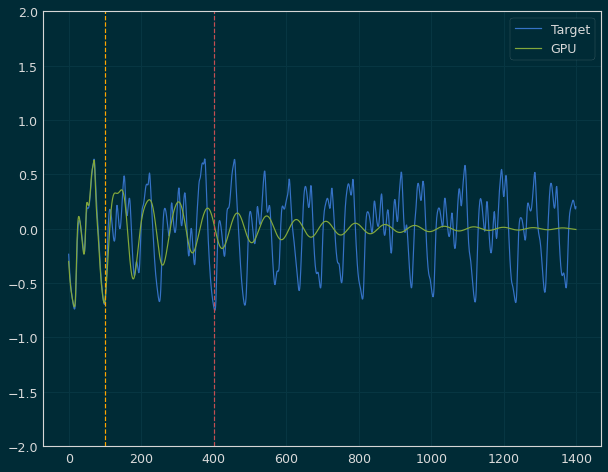

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.684684


Iter: 8 #### Diagnostic 0.684684   Time 6.64  Best 0.685 NRMSE 0.180 CD 0.505
Iter: 9 #### Diagnostic 1000.000000   Time 6.31  Best 0.685 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.417145   Time 6.31  Best 0.685 NRMSE 0.313 CD 1.105
Iter: 11 #### Diagnostic 1000.000000   Time 6.45  Best 0.685 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 6.39  Best 0.685 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.961846   Time 6.70  Best 0.685 NRMSE 0.200 CD 0.762
Iter: 14 #### Diagnostic 1000.000000   Time 6.26  Best 0.685 NRMSE 1000.000 CD nan


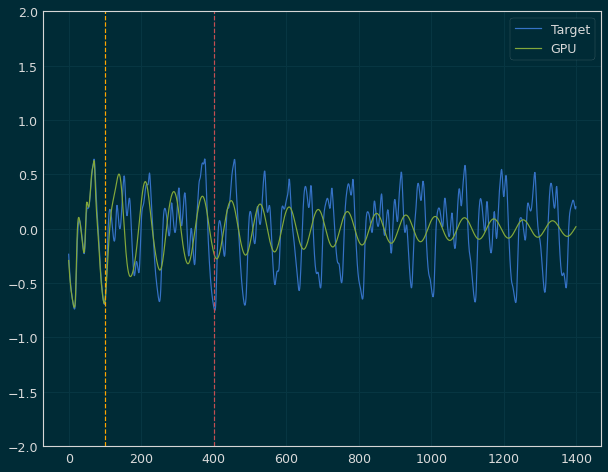

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.625229


Iter: 15 #### Diagnostic 0.625229   Time 6.80  Best 0.625 NRMSE 0.178 CD 0.447
Iter: 16 #### Diagnostic 1000.000000   Time 6.29  Best 0.625 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.28  Best 0.625 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.071093   Time 6.24  Best 0.625 NRMSE 0.243 CD 0.828
Iter: 19 #### Diagnostic 0.940237   Time 6.24  Best 0.625 NRMSE 0.193 CD 0.747
Iter: 20 #### Diagnostic 1000.000000   Time 6.31  Best 0.625 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.790065   Time 6.29  Best 0.625 NRMSE 0.186 CD 0.605
Iter: 22 #### Diagnostic 1000.000000   Time 6.24  Best 0.625 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 6.26  Best 0.625 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.29  Best 0.625 NRMSE 2429252703372913.000 CD 0.870
Iter: 25 #### Diagnostic 1000.000000   Time 6.26  Best 0.625 NRMSE 1000.000 CD nan
Iter: 26 #### Diag

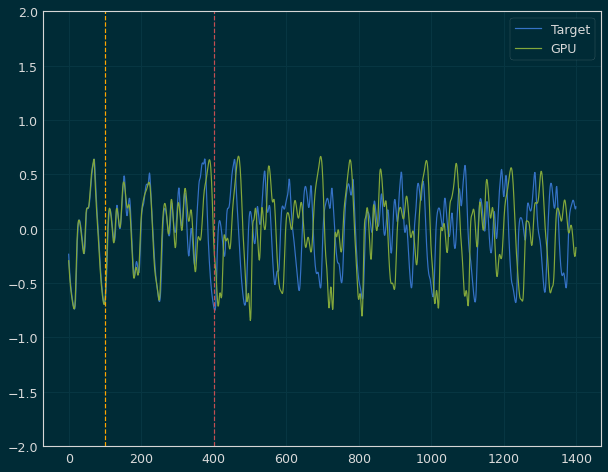

 Iter=43 a=0.419 sr=7.726 amp=0.154  ri=0.532 rr=2.039 loss=0.517470


Iter: 43 #### Diagnostic 0.517470   Time 6.64  Best 0.517 NRMSE 0.162 CD 0.356
Iter: 44 #### Diagnostic 1000.000000   Time 6.22  Best 0.517 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 6.24  Best 0.517 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.26  Best 0.517 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.23  Best 0.517 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 6.24  Best 0.517 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 6.31  Best 0.517 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 6.32  Best 0.517 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.33  Best 0.517 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.30  Best 0.517 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 6.25  Best 0.517 NRMSE 1000.000 CD nan
Iter: 54 #### Diagno

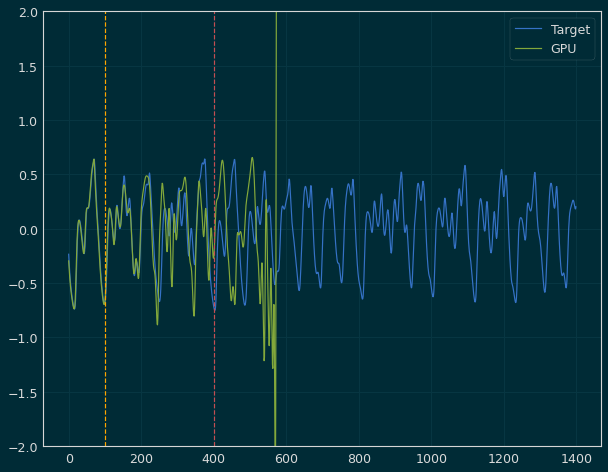

 Iter=60 a=0.415 sr=5.336 amp=0.264  ri=0.572 rr=3.962 loss=0.480283


Iter: 60 #### Diagnostic 0.480283   Time 6.70  Best 0.480 NRMSE 0.160 CD 0.320
Iter: 61 #### Diagnostic 1000.000000   Time 6.24  Best 0.480 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.450395   Time 6.28  Best 0.480 NRMSE 0.309 CD 1.142
Iter: 63 #### Diagnostic 1000.000000   Time 6.23  Best 0.480 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 6.24  Best 0.480 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 0.984589   Time 6.23  Best 0.480 NRMSE 0.195 CD 0.789
Iter: 66 #### Diagnostic 1.365782   Time 6.26  Best 0.480 NRMSE 0.252 CD 1.114
Iter: 67 #### Diagnostic 1.067735   Time 6.22  Best 0.480 NRMSE 0.222 CD 0.846
Iter: 68 #### Diagnostic 1.003101   Time 6.24  Best 0.480 NRMSE 0.221 CD 0.782
Iter: 69 #### Diagnostic 1.130617   Time 6.22  Best 0.480 NRMSE 0.222 CD 0.909
Iter: 70 #### Diagnostic 1000.000000   Time 6.24  Best 0.480 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 

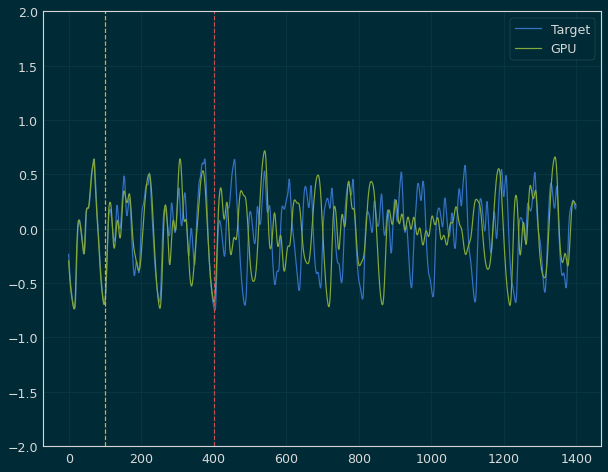

 Iter=3 a=0.407 sr=0.765 amp=0.910  ri=0.673 rr=4.132 loss=0.220216


Iter: 3 #### Diagnostic 0.220216   Time 6.69  Best 0.220 NRMSE 0.100 CD 0.120
Iter: 4 #### Diagnostic 0.534846   Time 6.34  Best 0.220 NRMSE 0.179 CD 0.356
Iter: 5 #### Diagnostic 1000.000000   Time 6.35  Best 0.220 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.35  Best 0.220 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.043068   Time 6.29  Best 0.220 NRMSE 0.200 CD 0.843
Iter: 8 #### Diagnostic 1.161866   Time 6.30  Best 0.220 NRMSE 0.241 CD 0.921
Iter: 9 #### Diagnostic 1000.000000   Time 6.70  Best 0.220 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.065782   Time 6.46  Best 0.220 NRMSE 0.257 CD 0.809
Iter: 11 #### Diagnostic 1.339385   Time 6.34  Best 0.220 NRMSE 0.285 CD 1.054
Iter: 12 #### Diagnostic 1.317214   Time 6.32  Best 0.220 NRMSE 0.237 CD 1.080
Iter: 13 #### Diagnostic 1.017377   Time 6.30  Best 0.220 NRMSE 0.249 CD 0.769
Iter: 14 #### Diagnostic 1.247145   Time 6.32  Best 0.22

Iter: 0 #### Diagnostic 1.273369   Time 6.84  Best 1000.000 NRMSE 0.264 CD 1.010
Iter: 1 #### Diagnostic 1.571188   Time 6.29  Best 1000.000 NRMSE 0.313 CD 1.258
Iter: 2 #### Diagnostic 1.497988   Time 6.31  Best 1000.000 NRMSE 0.310 CD 1.188
Iter: 3 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.668350   Time 6.33  Best 1000.000 NRMSE 0.340 CD 1.328
Iter: 5 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.998580   Time 6.34  Best 1000.000 NRMSE 0.196 CD 0.802
Iter: 11 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD na

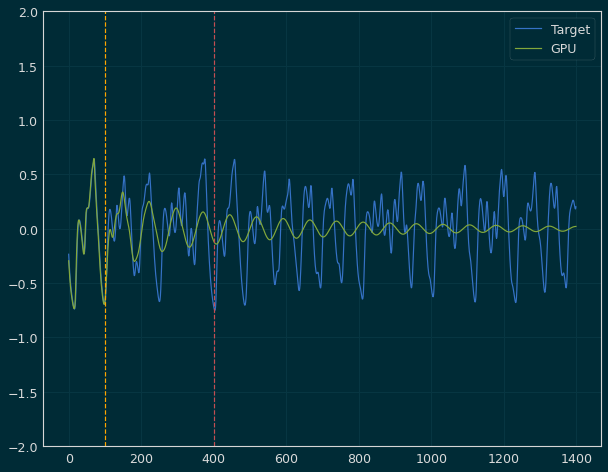

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.475030


Iter: 21 #### Diagnostic 0.475030   Time 8.77  Best 0.475 NRMSE 0.150 CD 0.325
Iter: 22 #### Diagnostic 1000.000000   Time 8.32  Best 0.475 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.272556   Time 7.37  Best 0.475 NRMSE 0.250 CD 1.023
Iter: 24 #### Diagnostic 0.912347   Time 6.36  Best 0.475 NRMSE 0.232 CD 0.680
Iter: 25 #### Diagnostic 44.363681   Time 6.36  Best 0.475 NRMSE 43.367 CD 0.996
Iter: 26 #### Diagnostic 1000.000000   Time 6.36  Best 0.475 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.28  Best 0.475 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.34  Best 0.475 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.157908   Time 6.81  Best 0.475 NRMSE 0.212 CD 0.946
Iter: 30 #### Diagnostic 1000.000000   Time 6.31  Best 0.475 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.37  Best 0.475 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.980251 

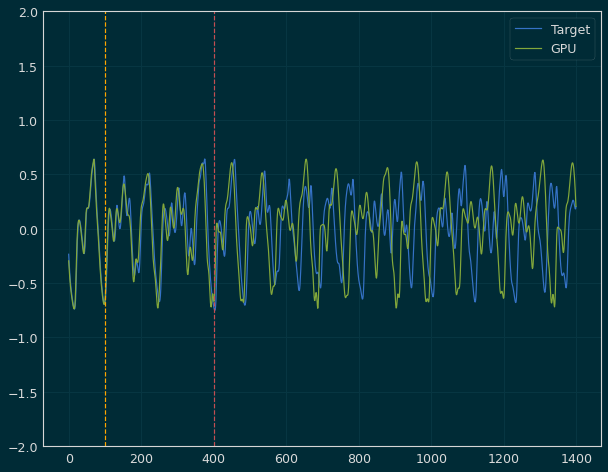

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.217896


Iter: 97 #### Diagnostic 0.217896   Time 6.65  Best 0.218 NRMSE 0.098 CD 0.119
Iter: 98 #### Diagnostic 1000.000000   Time 6.29  Best 0.218 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 6.29  Best 0.218 NRMSE 1000.000 CD nan

Best result = 0.21789615945585883
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 1000 ***********
Iter: 0 #### Diagnostic 0.995287   Time 6.32  Best 1000.000 NRMSE 0.196 CD 0.799
Iter: 1 #### Diagnostic 1000.000000   Time 6.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 13947173091.411 CD 1.127
Iter: 3 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan


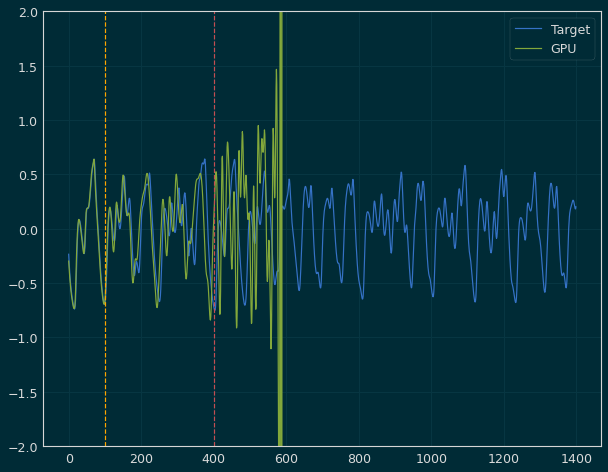

 Iter=4 a=0.348 sr=4.500 amp=0.513  ri=0.347 rr=1.725 loss=0.548455


Iter: 4 #### Diagnostic 0.548455   Time 6.71  Best 0.548 NRMSE 0.175 CD 0.373
Iter: 5 #### Diagnostic 1000.000000   Time 6.28  Best 0.548 NRMSE 3289.700 CD 0.997
Iter: 6 #### Diagnostic 1000.000000   Time 6.27  Best 0.548 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.026367   Time 6.27  Best 0.548 NRMSE 0.226 CD 0.800
Iter: 8 #### Diagnostic 1000.000000   Time 6.29  Best 0.548 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.608595   Time 6.32  Best 0.548 NRMSE 0.186 CD 0.422
Iter: 10 #### Diagnostic 1.610712   Time 7.10  Best 0.548 NRMSE 0.304 CD 1.306
Iter: 11 #### Diagnostic 1000.000000   Time 6.29  Best 0.548 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 6.32  Best 0.548 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 6.39  Best 0.548 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.87  Best 0.548 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000 

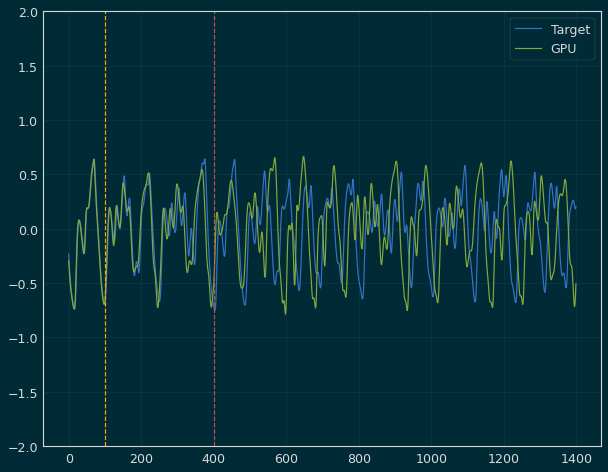

 Iter=33 a=0.722 sr=1.044 amp=0.987  ri=0.297 rr=1.165 loss=0.268064


Iter: 33 #### Diagnostic 0.268064   Time 6.71  Best 0.268 NRMSE 0.112 CD 0.156
Iter: 34 #### Diagnostic 1000.000000   Time 6.28  Best 0.268 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.573298   Time 6.28  Best 0.268 NRMSE 0.181 CD 0.393
Iter: 36 #### Diagnostic 1000.000000   Time 6.29  Best 0.268 NRMSE 12289801646435747840.000 CD 1.000
Iter: 37 #### Diagnostic 0.996436   Time 6.30  Best 0.268 NRMSE 0.197 CD 0.799
Iter: 38 #### Diagnostic 0.825268   Time 6.42  Best 0.268 NRMSE 0.192 CD 0.633
Iter: 39 #### Diagnostic 0.991520   Time 6.28  Best 0.268 NRMSE 0.199 CD 0.793
Iter: 40 #### Diagnostic 1.201544   Time 6.29  Best 0.268 NRMSE 0.219 CD 0.982
Iter: 41 #### Diagnostic 1.077901   Time 6.28  Best 0.268 NRMSE 0.202 CD 0.875
Iter: 42 #### Diagnostic 1.117082   Time 6.27  Best 0.268 NRMSE 0.263 CD 0.854
Iter: 43 #### Diagnostic 1000.000000   Time 6.40  Best 0.268 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.

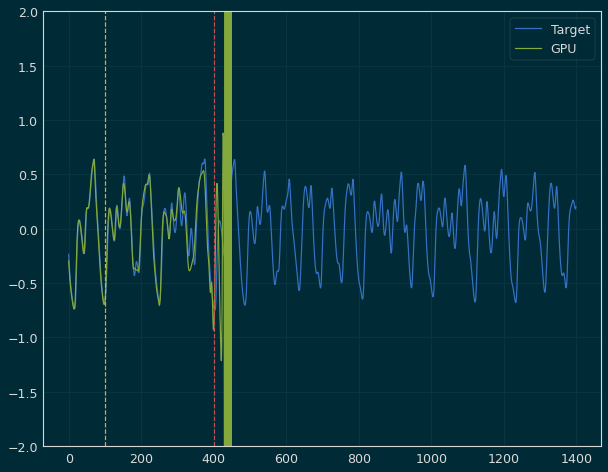

 Iter=81 a=0.625 sr=2.260 amp=0.852  ri=0.573 rr=2.977 loss=0.113886


Iter: 81 #### Diagnostic 0.113886   Time 6.65  Best 0.114 NRMSE 0.064 CD 0.050
Iter: 82 #### Diagnostic 1.194826   Time 6.27  Best 0.114 NRMSE 0.210 CD 0.984
Iter: 83 #### Diagnostic 1000.000000   Time 6.27  Best 0.114 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.29  Best 0.114 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.26  Best 0.114 NRMSE 490581.972 CD 1.094
Iter: 86 #### Diagnostic 1000.000000   Time 6.27  Best 0.114 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.076275   Time 6.28  Best 0.114 NRMSE 0.203 CD 0.873
Iter: 88 #### Diagnostic 1000.000000   Time 6.25  Best 0.114 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.341523   Time 6.27  Best 0.114 NRMSE 0.233 CD 1.109
Iter: 90 #### Diagnostic 0.913859   Time 6.83  Best 0.114 NRMSE 0.227 CD 0.687
Iter: 91 #### Diagnostic 1.073831   Time 6.29  Best 0.114 NRMSE 0.202 CD 0.872
Iter: 92 #### Diagnostic 1.199064   

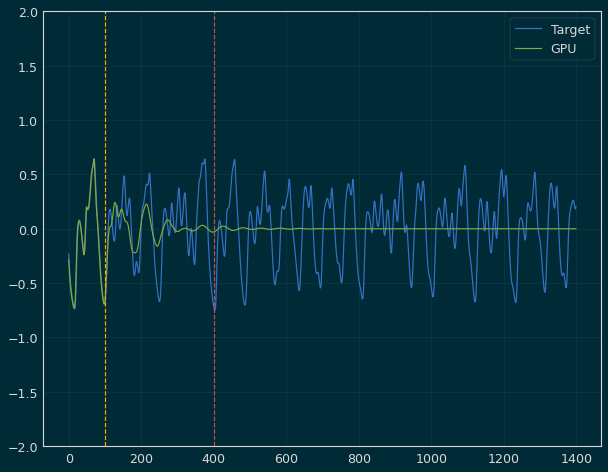

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.565821


Iter: 2 #### Diagnostic 0.565821   Time 7.26  Best 0.566 NRMSE 0.164 CD 0.402
Iter: 3 #### Diagnostic 1000.000000   Time 6.64  Best 0.566 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.27  Best 0.566 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.26  Best 0.566 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.872934   Time 6.26  Best 0.566 NRMSE 0.228 CD 0.645
Iter: 7 #### Diagnostic 1000.000000   Time 6.28  Best 0.566 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.877130   Time 6.27  Best 0.566 NRMSE 0.208 CD 0.669
Iter: 9 #### Diagnostic 1000.000000   Time 6.57  Best 0.566 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 6.26  Best 0.566 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.239855   Time 6.68  Best 0.566 NRMSE 0.255 CD 0.984
Iter: 12 #### Diagnostic 1000.000000   Time 6.52  Best 0.566 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Ti

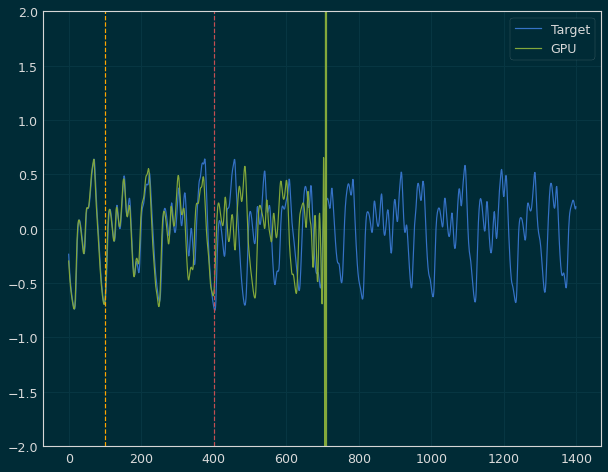

 Iter=24 a=0.883 sr=2.510 amp=0.710  ri=0.903 rr=4.681 loss=0.183048


Iter: 24 #### Diagnostic 0.183048   Time 7.51  Best 0.183 NRMSE 0.087 CD 0.096
Iter: 25 #### Diagnostic 1000.000000   Time 7.15  Best 0.183 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.361332   Time 7.23  Best 0.183 NRMSE 0.133 CD 0.228
Iter: 27 #### Diagnostic 1000.000000   Time 7.05  Best 0.183 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.216088   Time 7.30  Best 0.183 NRMSE 0.267 CD 0.949
Iter: 29 #### Diagnostic 1000.000000   Time 7.49  Best 0.183 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.910546   Time 6.57  Best 0.183 NRMSE 0.191 CD 0.719
Iter: 31 #### Diagnostic 1000.000000   Time 6.32  Best 0.183 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 6.29  Best 0.183 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.226908   Time 6.28  Best 0.183 NRMSE 0.234 CD 0.993
Iter: 34 #### Diagnostic 1.251738   Time 6.28  Best 0.183 NRMSE 0.220 CD 1.032
Iter: 35 #### Diagnostic 1000.000000   T

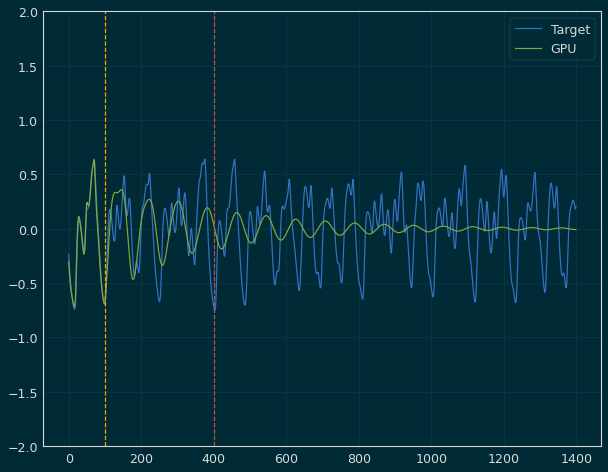

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.672494


Iter: 8 #### Diagnostic 0.672494   Time 9.31  Best 0.672 NRMSE 0.178 CD 0.494
Iter: 9 #### Diagnostic 1000.000000   Time 7.73  Best 0.672 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 7.28  Best 0.672 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 8.78  Best 0.672 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.22  Best 0.672 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.961399   Time 6.92  Best 0.672 NRMSE 0.200 CD 0.762
Iter: 14 #### Diagnostic 1000.000000   Time 7.12  Best 0.672 NRMSE 1000.000 CD nan


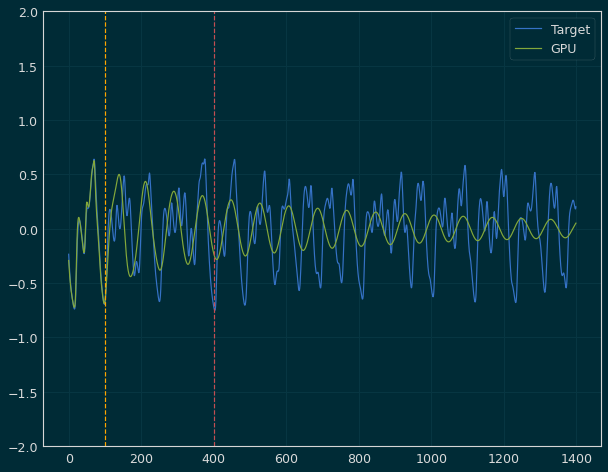

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.616420


Iter: 15 #### Diagnostic 0.616420   Time 7.79  Best 0.616 NRMSE 0.177 CD 0.440
Iter: 16 #### Diagnostic 1000.000000   Time 7.56  Best 0.616 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.43  Best 0.616 NRMSE 1000.000 CD nan


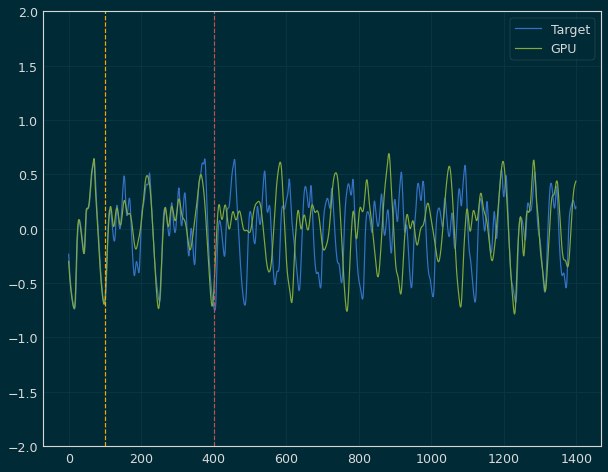

 Iter=18 a=0.258 sr=4.123 amp=0.197  ri=0.514 rr=0.186 loss=0.189878


Iter: 18 #### Diagnostic 0.189878   Time 8.18  Best 0.190 NRMSE 0.088 CD 0.102
Iter: 19 #### Diagnostic 0.948456   Time 9.17  Best 0.190 NRMSE 0.194 CD 0.755
Iter: 20 #### Diagnostic 1000.000000   Time 10.09  Best 0.190 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.787535   Time 7.29  Best 0.190 NRMSE 0.185 CD 0.602
Iter: 22 #### Diagnostic 1000.000000   Time 7.13  Best 0.190 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.27  Best 0.190 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 7.16  Best 0.190 NRMSE 3806898021.631 CD 0.857
Iter: 25 #### Diagnostic 1000.000000   Time 6.59  Best 0.190 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.30  Best 0.190 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 0.831598   Time 6.46  Best 0.190 NRMSE 0.203 CD 0.629
Iter: 28 #### Diagnostic 1000.000000   Time 6.33  Best 0.190 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnosti

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda().type(dtype)

size = [1000,900,800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [18,18,79,36,47,16,59,36,91,43,133,43,111,43,135,43,80,0,43,39]
size = [1000]#,950,900,850,800,750,700,650,600,550,500,
        #450,400,350,300,250,200,150,100,50]

TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelMG/Mats/MG_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelMG/Params/MG_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    mm_ranks.append(ave_rank)

In [ ]:
    
np.save('./MultiModelMG/MG_MMranks',np.array(mm_ranks))

In [ ]:
plt.plot(size,mm_ranks)
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelMG/Preds/MG_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    nrmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(nrmse/minmax)
    err_list.append(nrmse/minmax)
np.save('./MultiModelMG/MG_mm_errors',np.array(err_list))

plt.plot(size,err_list)
plt.show()

In [ ]:
total = 0.
no_outliers = []
for i in range(len(mm_ranks)):
    if(size[i] in [600,1000]):
        pass
    else:
        total += mm_ranks[i]
        no_outliers.append(mm_ranks[i])
total/(len(mm_ranks)-2)